<a href="https://colab.research.google.com/github/tengfeixia/RN_avec_des_incertitudes_propag-es/blob/main/DNN_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split


print ("TF Version", tf.__version__)

TF Version 2.5.0


(10000, 1)


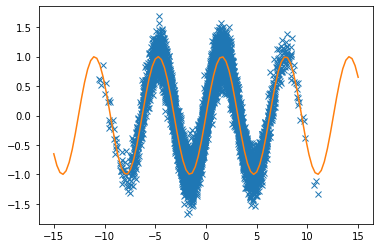

In [2]:
# generate data

X= 3*np.random.randn (10000,1)
sigmay = 0.2*np.random.randn (10000,1)
X= X

print (np.shape(X))
Y= np.sin(X)+sigmay
plt.plot (X[:,0],Y[:,0], "x", markersize = 6) #gerenrate data by fonction y = sin (6x) avec des incertitudes aléatories sur x


x = np.linspace(-15,15,100) #print the cruve sin (6x)
y =np.sin(x)
plt.plot (x,y)


In [3]:
class Layer:

    def __init__ (self,n_input,n_neurons, activation = None, weights = None, bias = None):

        """
        int n_input: nb de noeuds entrées (nb de noeuds de la couche précédente)
        int n_neurons: nb de noeuds sorties (nb de noeuds de la couche actuelle)
        str activation: type de la fonction d'activation 
        weights, bias: généré dans les couches
        """

        self.weights = weights if weights is not None else np.random.randn(n_input,n_neurons)*np.sqrt(2/(n_neurons+n_input))
        print ("weights", self.weights)

        
        self.bias = bias if bias is not None else np.zeros((n_neurons))
        print ("bias", self.bias)
                        
        self.nb_neurons = n_neurons 

        self.activation = activation
        self.activation_value = None
        self.error = None
        self.delta = None
        self.gradient = None
        self.x = None
        self.z = None

        # feed forward propagation

    def feedforward (self,x):
        self.x = x
    
        z = np.dot (x,self.weights) + self.bias # z = wx+b
        self.z =z
        self.activation_value = self.apply_activation (z)

        return self.activation_value

        # fonction d'activaiton

    def apply_activation(self, z):

        if self.activation is None:
            return z
        elif self.activation == "relu":
            return np.maximum(z, 0)
        elif self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z))
    

        # dérivés des fonctions d'activation,， attention le input c'est a, value activé
    def apply_activation_derivation(self, a):

        if self.activation is None:
            return np.ones_like(a)
        elif self.activation == "relu":
            grad = np.array(a, copy=True)
            grad[a > 0] = 1.
            grad[a<= 0] = 0.
            return grad
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "sigmoid":
            return a* (1 - a)



weights [[ 0.23513041 -0.67608424 -0.25292458  0.40291172]]
bias [0. 0. 0. 0.]
weights [[ 0.34675344 -0.25906824 -0.0043559  -0.42311299]
 [ 0.63239773 -0.0676943  -0.64456367  0.06027298]
 [-0.59392052  0.69444536 -0.32969689 -0.08263787]
 [-0.18629181 -0.50818449 -0.22645032 -0.95884108]]
bias [0. 0. 0. 0.]
weights [[-0.26076279 -0.08598431]
 [-1.45680913 -0.16101373]
 [-1.11382569  0.00302479]
 [-0.26033643  0.33872813]]
bias [0. 0.]
weights [[ 0.211833  ]
 [-0.25237894]]
bias [0.]
MSE train: 0.41010083281778303
MSE train: 0.1660485111330691
MSE train: 0.15402269206311103
MSE train: 0.14730244790894723
MSE train: 0.14193906452077298
MSE train: 0.13659634414587205
MSE train: 0.13132926030991
MSE train: 0.12663265824129843
MSE train: 0.12269307737928235
MSE train: 0.11942541448706925
MSE train: 0.11667898059494182
MSE train: 0.11431496683171914
MSE train: 0.11221951579978248
MSE train: 0.11030052840187424
MSE train: 0.10848321137519101
MSE train: 0.10670830305696571
MSE train: 0.10493

Text(0, 0.5, 'MSE')

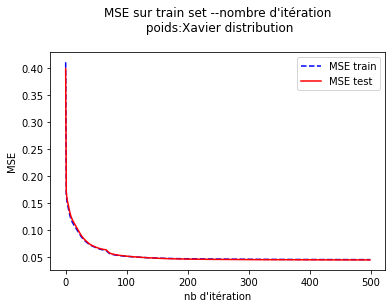

In [6]:
# Neural Network

class NN:
    def __init__ (self):
        self.__layers = []


    def add_layer (self, layer): #add layer
        self.__layers.append(layer)

    def feed_forward (self, X): # X --> my_nn.feed_forward (X) --> y_predict
        for layer in self.__layers:
            X = layer.feedforward (X)
        return X

    def back_propagation (self, X_train, y_train, lr):
        output = self.feed_forward(X_train)
        
        
        #print ("output",output )

        for i in reversed(range(len(self.__layers))):
            current_layer = self.__layers[i] #get layer            
    
            if current_layer == self.__layers [-1]:  # si la couche output
                current_layer.error = output - y_train
                """
                print ("y_predict\n", y_predict)
                print ("y_train\n", y_train)
                print ("layer error",current_layer.error)
                print ("\n")
                """
                current_layer.delta = 2*current_layer.error * current_layer.apply_activation_derivation (output )

                previous_layer = self.__layers [i-1]

                current_layer.weights -= current_layer.delta*(np.atleast_2d(previous_layer.activation_value)).T*lr
                current_layer.bias -= current_layer.delta*lr

            
            else:
                next_layer = self.__layers[i+1] #les incertitudes dépendent de la couche prochaine

                current_layer.error = np.dot(next_layer.weights, next_layer.delta)

                current_layer.delta = current_layer.error* current_layer.apply_activation_derivation(current_layer.activation_value)

                current_layer.bias -= current_layer.delta*lr

                if current_layer != self.__layers [0]:
                    previous_layer = self.__layers [i-1]
                    current_layer.weights -= current_layer.delta*(np.atleast_2d(previous_layer.activation_value)).T*lr

                else :
                    current_layer.weights -= current_layer.delta*(np.atleast_2d(X_train)).T*lr


    def train (self,X_train,X_test,y_train, y_test, lr, epochs):
        mses_train = []
        mses_test = []
        
        for i in range (epochs):
            for j in range (len (X_train)):
                self.back_propagation(X_train[j],y_train[j],lr)

            monitor = mse_test = 100
            mse_test = np.mean(np.square(self.feed_forward(X_test)- y_test))
            mses_test.append (mse_test)
            
            if i % 1 ==0:
                    
                mse_train = np.mean(np.square(self.feed_forward(X_train)- y_train))
                print ("MSE train:", mse_train)
                mses_train.append(mse_train)
         

        return mses_train, mses_test



    


my_nn = NN()
my_nn.add_layer(Layer(1, 4, "tanh")) 
my_nn.add_layer(Layer(4, 4, "tanh")) 
my_nn.add_layer(Layer(4, 2, "tanh"))
my_nn.add_layer(Layer(2, 1, None)) 


X_train, X_test, y_train, y_test = train_test_split (X,Y,test_size = 0.25)

mses_train,mses_test = my_nn.train(X_train,X_test,y_train,y_test,0.001,500)


plt.figure()
plt.plot(mses_train, '--b', label='MSE train')
plt.plot(mses_test, 'r',label = 'MSE test')
plt.legend()
plt.title ("MSE sur train set --nombre d'itération\n poids:Xavier distribution\n")
plt.xlabel ("nb d'itération")
plt.ylabel ("MSE")

Text(0, 0.5, 'y')

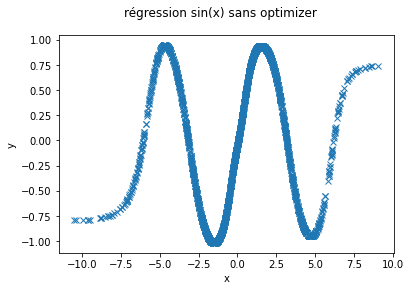

In [7]:
plt.figure()
plt.suptitle("régression sin(x) sans optimizer")
plt.plot (X_test,my_nn.feed_forward(X_test), "x", markersize = 6)
plt.xlabel ("x")
plt.ylabel ("y")

Text(0, 0.5, 'MSE')

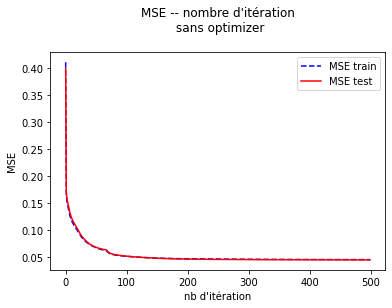

In [8]:

plt.figure()
plt.plot(mses_train, '--b', label='MSE train')
plt.plot(mses_test, 'r',label = 'MSE test')
plt.legend()
plt.title ("MSE -- nombre d'itération\n sans optimizer\n")
plt.xlabel ("nb d'itération")
plt.ylabel ("MSE")

In [10]:
class Layer:

    def __init__ (self,n_input,n_neurons, activation = None, weights = None, bias = None):

        """
        int n_input: nb de noeuds entrées (nb de noeuds de la couche précédente)
        int n_neurons: nb de noeuds sorties (nb de noeuds de la couche actuelle)
        str activation: type de la fonction d'activation 
        weights, bias: généré dans les couches
        """

        self.weights = weights if weights is not None else np.random.randn(n_input,n_neurons)*np.sqrt(2/(n_input+n_neurons))
        print ("weights", self.weights)
        #np.sqrt(1/n_neurons)
        
        self.bias = bias if bias is not None else np.zeros((n_neurons))
        print ("bias", self.bias)
                        
        self.nb_neurons = n_neurons 

        self.activation = activation
        self.activation_value = None
        self.error = None
        self.delta = None
        self.gradient = None
        self.x = None
        self.z = None

        #pour adam
        #bias
        self.v_b = 0
        self.grad_sq_b = 0
        self.v_hat_b = 0
        self.grad_sq_hat_b = 0

        #weights
        self.v_w = 0
        self.grad_sq_w = 0
        self.v_hat_w = 0
        self.grad_sq_hat_w = 0
        self.grad = None 

        # feed forward propagation

    def feedforward (self,x):
        self.x = x
    
        z = np.dot (x,self.weights) + self.bias # z = wx+b
        self.z =z
        self.activation_value = self.apply_activation (z)
        #print (self.__activation_value)
        return self.activation_value

        # fonction d'activaiton

    def apply_activation(self, z):

        if self.activation is None:
            return z
        elif self.activation == "relu":
            return np.maximum(z, 0)
        elif self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z))
    

        # dérivés des fonctions d'activation,， attention le input c'est a, value activé
    def apply_activation_derivation(self, a):

        if self.activation is None:
            return np.ones_like(a)
        elif self.activation == "relu":
            grad = np.array(a, copy=True)
            grad[a > 0] = 1.
            grad[a<= 0] = 0.
            return grad
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "sigmoid":
            return a* (1 - a)

weights [[ 0.31049569 -0.34231536 -0.46122074 -0.38647614]]
bias [0. 0. 0. 0.]
weights [[-0.3265954  -0.11365652 -0.33328261  0.85529612]
 [ 0.32220486 -0.0360981   0.25229772 -0.33178595]
 [ 0.79859802  0.8083052  -0.35129338  0.26960601]
 [-0.1230477   0.6869016   0.94169106 -0.4668135 ]]
bias [0. 0. 0. 0.]
weights [[ 0.07912289  0.02285282]
 [ 1.06351936  0.86796141]
 [-0.74039823  0.22290136]
 [-0.12540896  0.73224558]]
bias [0. 0.]
weights [[-0.2708661 ]
 [-0.21165571]]
bias [0.]


Text(0, 0.5, 'MSE')

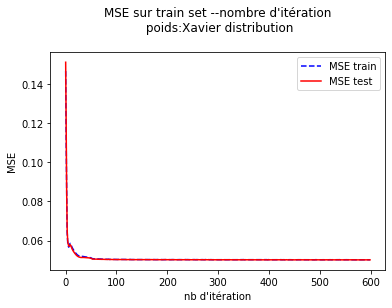

In [11]:
# Neural Network

class NN:
    def __init__ (self):
        self.__layers = []
        
        #paramètres adam
        self.gamma = 0.9
        self.beta = 0.99
        self.epsilon = 10**-8
        

    def add_layer (self, layer): #add layer
        self.__layers.append(layer)

    def feed_forward (self, X): # X --> my_nn.feed_forward (X) --> y_predict
        for layer in self.__layers:
            X = layer.feedforward (X)
        return X

    def back_propagation (self, X_train, y_train, lr):
        y_predict = self.feed_forward(X_train)

    

        for i in reversed(range(len(self.__layers))):
            current_layer = self.__layers[i] #get layer            
    
            if current_layer == self.__layers [-1]:  # si current == couche output
                current_layer.error = y_predict - y_train
                
                current_layer.delta = 2*current_layer.error * current_layer.apply_activation_derivation (y_predict)
                
                previous_layer = self.__layers [i-1]
                
                #print ("delta_output", current_layer.delta)

                #adam pour bias            
                current_layer.v_b = self.gamma*current_layer.v_b + (1-self.gamma)*current_layer.delta
                current_layer.grad_sq_b = self.beta*current_layer.grad_sq_b + (1- self.beta)*np.square (current_layer.delta)
                current_layer.v_hat_b = current_layer.v_b / (1- self.gamma)
                current_layer.grad_sq_hat_b = current_layer.grad_sq_b / (1- self.beta)
                #print ("test1",current_layer.bias)
                current_layer.bias -= lr * np.divide (current_layer.v_hat_b, np.sqrt (current_layer.grad_sq_hat_b+ self.epsilon) )

                #print ("test2",current_layer.bias)
                
                
                #adam pour weights
                
                current_layer.grad = current_layer.delta*(np.atleast_2d(previous_layer.activation_value)).T
                current_layer.v_w = self.gamma*current_layer.v_w + (1-self.gamma)*current_layer.grad
                current_layer.grad_sq_w= self.beta*current_layer.grad_sq_w + (1-self.beta)*np.square(current_layer.grad)
                current_layer.v_hat_w = current_layer.v_w / (1- self.gamma)
                current_layer.grad_sq_hat_w = current_layer.grad_sq_w/ (1- self.gamma)
                current_layer.weights -= lr*np.divide(current_layer.v_hat_w,np.sqrt(current_layer.grad_sq_hat_w+self.epsilon))
                

            
            else:
                next_layer = self.__layers[i+1] #les incertitudes dépendent de la couche prochaine
                
                current_layer.error = np.dot(next_layer.weights, next_layer.delta)
             
                current_layer.delta = current_layer.error* current_layer.apply_activation_derivation(current_layer.activation_value)

                #print ("delta_layers", current_layer.delta)

                # ________________________________adam pour bias
                current_layer.v_b = self.gamma*current_layer.v_b + (1-self.gamma)*current_layer.delta
                current_layer.grad_sq_b = self.beta*current_layer.grad_sq_b + (1- self.beta)*np.square (current_layer.delta)
                current_layer.v_hat_b = current_layer.v_b / (1- self.gamma)
                current_layer.grad_sq_hat_b = current_layer.grad_sq_b / (1- self.beta)
                #print ("test3",current_layer.bias)
                current_layer.bias -= lr * np.divide (current_layer.v_hat_b, np.sqrt (current_layer.grad_sq_hat_b+ self.epsilon) )
                #print ("test4",current_layer.bias)

                #__________________________________adam pour weights

                
                previous_layer = self.__layers [i-1]
    
                current_layer.grad = current_layer.delta*(np.atleast_2d(previous_layer.activation_value if current_layer != self.__layers [0] else X_train )).T
                current_layer.v_w = self.gamma*current_layer.v_w + (1-self.gamma)*current_layer.grad
                current_layer.grad_sq_w= self.beta*current_layer.grad_sq_w + (1-self.beta)*np.square(current_layer.grad)
                current_layer.v_hat_w = current_layer.v_w / (1- self.gamma)
                current_layer.grad_sq_hat_w = current_layer.grad_sq_w/ (1- self.gamma)
                current_layer.weights -= lr*np.divide(current_layer.v_hat_w,np.sqrt(current_layer.grad_sq_hat_w+self.epsilon))



    def train (self,X_train,X_test,y_train, y_test, lr, epochs):
        mses_train = []
        mses_test = []
        
        for i in range (epochs):
            for j in range (len (X_train)):
                self.back_propagation(X_train[j],y_train[j],lr)

            monitor = mse_test = 100
            mse_test = np.mean(np.square(self.feed_forward(X_test)- y_test))
            mses_test.append (mse_test)
            
            if i % 1 ==0:
                    
                mse_train = np.mean(np.square(self.feed_forward(X_train)- y_train))
                mses_train.append(mse_train)



        return mses_train, mses_test



    


my_nn = NN()
my_nn.add_layer(Layer(1, 4, "tanh")) 
my_nn.add_layer(Layer(4, 4, "tanh")) 
my_nn.add_layer(Layer(4, 2, "tanh"))
my_nn.add_layer(Layer(2, 1, None)) 


#X_train, X_test, y_train, y_test = train_test_split (X,Y,test_size = 0.25)

mses_train_adam,mses_test_adam = my_nn.train(X_train,X_test,y_train,y_test,0.001,600)


plt.figure()
plt.plot(mses_train_adam, '--b', label='MSE train')
plt.plot(mses_test_adam, 'r',label = 'MSE test')
plt.legend()
plt.title ("MSE sur train set --nombre d'itération\n poids:Xavier distribution\n")
plt.xlabel ("nb d'itération")
plt.ylabel ("MSE")
    



Text(0, 0.5, 'y')

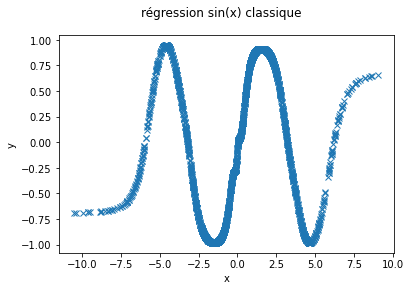

In [12]:
plt.figure()
plt.suptitle("régression sin(x) classique")
plt.plot (X_test,my_nn.feed_forward(X_test), "x", markersize = 6)
plt.xlabel ("x")
plt.ylabel ("y")

Text(0, 0.5, 'MSE')

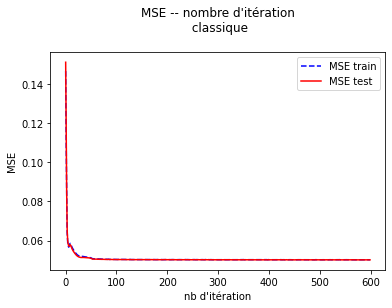

In [13]:

plt.figure()
plt.plot(mses_train_adam, '--b', label='MSE train')
plt.plot(mses_test_adam, 'r',label = 'MSE test')
plt.legend()
plt.title ("MSE -- nombre d'itération\n classique\n")
plt.xlabel ("nb d'itération")
plt.ylabel ("MSE")

Text(0, 0.5, 'MSE')

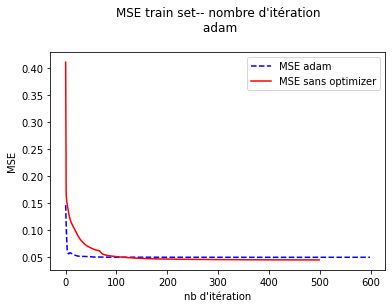

In [14]:

plt.figure()
plt.plot(mses_train_adam, '--b', label='MSE adam')
plt.plot(mses_train, 'r',label = 'MSE sans optimizer')
plt.legend()
plt.title ("MSE train set-- nombre d'itération\n adam\n")
plt.xlabel ("nb d'itération")
plt.ylabel ("MSE")

Text(0, 0.5, 'MSE')

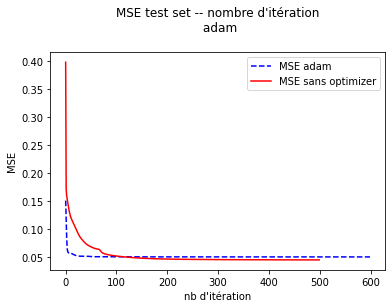

In [15]:

plt.figure()
plt.plot(mses_test_adam, '--b', label='MSE adam')
plt.plot(mses_test, 'r',label = 'MSE sans optimizer')
plt.legend()
plt.title ("MSE test set -- nombre d'itération\n adam\n")
plt.xlabel ("nb d'itération")
plt.ylabel ("MSE")